In [1]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.5 MB/s eta 0:00:00


## Api weather open-meteo

In [2]:
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

In [3]:
def GetHistoricalData(params, url):
  cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
  retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
  openmeteo = openmeteo_requests.Client(session = retry_session)

  responses = openmeteo.weather_api(url, params=params)

   # Process first location. Add a for-loop for multiple locations or weather models
  response = responses[0]
  print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
  print(f"Elevation {response.Elevation()} m asl")
  print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
  print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

  # Process hourly data. The order of variables needs to be the same as requested.
  hourly = response.Hourly()
  hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
  hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
  hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
  hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
  hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()
  hourly_rain = hourly.Variables(5).ValuesAsNumpy()
  hourly_snowfall = hourly.Variables(6).ValuesAsNumpy()
  hourly_snow_depth = hourly.Variables(7).ValuesAsNumpy()

  hourly_data = {
      "datetime": pd.date_range(
      start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
      end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
      freq = pd.Timedelta(seconds = hourly.Interval()),
      inclusive = "left"
  )}
  hourly_data["temperature_2m"] = hourly_temperature_2m
  hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
  hourly_data["dew_point_2m"] = hourly_dew_point_2m
  hourly_data["apparent_temperature"] = hourly_apparent_temperature
  hourly_data["precipitation"] = hourly_precipitation
  hourly_data["rain"] = hourly_rain
  hourly_data["snowfall"] = hourly_snowfall
  hourly_data["snow_depth"] = hourly_snow_depth

  hourly_dataframe = pd.DataFrame(data = hourly_data)
  print(hourly_dataframe)

  hourly_dataframe['time'] = hourly_dataframe['datetime'].dt.time
  hourly_dataframe['date'] = hourly_dataframe['datetime'].dt.date

  # Process daily data. The order of variables needs to be the same as requested.
  daily = response.Daily()
  daily_weather_code = daily.Variables(0).ValuesAsNumpy()
  daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
  daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
  daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
  daily_apparent_temperature_max = daily.Variables(4).ValuesAsNumpy()
  daily_apparent_temperature_min = daily.Variables(5).ValuesAsNumpy()
  daily_apparent_temperature_mean = daily.Variables(6).ValuesAsNumpy()
  daily_sunrise = daily.Variables(7).ValuesAsNumpy()
  daily_sunset = daily.Variables(8).ValuesAsNumpy()
  daily_daylight_duration = daily.Variables(9).ValuesAsNumpy()
  daily_sunshine_duration = daily.Variables(10).ValuesAsNumpy()
  daily_precipitation_sum = daily.Variables(11).ValuesAsNumpy()
  daily_rain_sum = daily.Variables(12).ValuesAsNumpy()
  daily_snowfall_sum = daily.Variables(13).ValuesAsNumpy()
  daily_precipitation_hours = daily.Variables(14).ValuesAsNumpy()
  daily_wind_speed_10m_max = daily.Variables(15).ValuesAsNumpy()
  daily_wind_gusts_10m_max = daily.Variables(16).ValuesAsNumpy()

  daily_data = {
      "datetime": pd.date_range(
      start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
      end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
      freq = pd.Timedelta(seconds = daily.Interval()),
      inclusive = "left"
  )}
  daily_data["weather_code"] = daily_weather_code
  daily_data["temperature_2m_max"] = daily_temperature_2m_max
  daily_data["temperature_2m_min"] = daily_temperature_2m_min
  daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
  daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
  daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
  daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
  daily_data["sunrise"] = daily_sunrise
  daily_data["sunset"] = daily_sunset
  daily_data["daylight_duration"] = daily_daylight_duration
  daily_data["sunshine_duration"] = daily_sunshine_duration
  daily_data["precipitation_sum"] = daily_precipitation_sum
  daily_data["rain_sum"] = daily_rain_sum
  daily_data["snowfall_sum"] = daily_snowfall_sum
  daily_data["precipitation_hours"] = daily_precipitation_hours
  daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
  daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
  daily_dataframe = pd.DataFrame(data = daily_data)

  daily_dataframe['time'] = daily_dataframe['datetime'].dt.time
  daily_dataframe['date'] = daily_dataframe['datetime'].dt.date

  return daily_dataframe, hourly_dataframe


In [4]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
  "latitude": 40.7143,
 	"longitude" : -74.006,
	"hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "precipitation", "rain", "snowfall", "snow_depth"],
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max"],
  "timezone": "Europe/Berlin",
	"end_date": "2024-06-01",
	"start_date": "1980-01-01"
}

data_daily, data_hourly = GetHistoricalData(params, url)


Coordinates 40.738136291503906°N -74.04254150390625°E
Elevation 51.0 m asl
Timezone b'Europe/Berlin' b'CEST'
Timezone difference to GMT+0 7200 s
                        datetime  temperature_2m  relative_humidity_2m  \
0      1979-12-31 22:00:00+00:00        3.283500             62.650139   
1      1979-12-31 23:00:00+00:00        2.483500             59.032410   
2      1980-01-01 00:00:00+00:00        2.633500             57.749485   
3      1980-01-01 01:00:00+00:00        1.883500             62.310638   
4      1980-01-01 02:00:00+00:00        1.183500             68.278381   
...                          ...             ...                   ...   
389371 2024-06-01 17:00:00+00:00       26.622499             29.691801   
389372 2024-06-01 18:00:00+00:00       27.272499             28.095020   
389373 2024-06-01 19:00:00+00:00       27.772499             27.191765   
389374 2024-06-01 20:00:00+00:00       27.922499             26.954706   
389375 2024-06-01 21:00:00+00:00       27

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_weather_data(weather_data,  end_datetime=None, start_datetime=None):
    # Konwersja start_datetime i end_datetime na datetime64[ns, UTC]
    if start_datetime:
        start_datetime = pd.to_datetime(start_datetime, utc=True)
    if end_datetime:
        end_datetime = pd.to_datetime(end_datetime, utc=True)

    # Filtracja danych według przedziału czasowego
    if start_datetime and end_datetime:
        mask = (weather_data['datetime'] >= start_datetime) & (weather_data['datetime'] <= end_datetime)
    elif start_datetime:
        mask = (weather_data['datetime'] >= start_datetime)
    elif end_datetime:
        mask = (weather_data['datetime'] <= end_datetime)
    else:
        mask = pd.Series([True] * len(weather_data))

    filtered_data = weather_data[mask]

    # Pobranie dat i temperatur z przefiltrowanych danych
    times = filtered_data['datetime']
    temperatures = filtered_data['temperature_2m_max']
    print(times)
    print(temperatures)
    # Tworzenie wykresu
    plt.figure(figsize=(10, 5))
    plt.plot(times, temperatures, label="Temperature (°C)")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.title("Historical Temperature Data")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

7306    2000-01-01 22:00:00+00:00
7307    2000-01-02 22:00:00+00:00
7308    2000-01-03 22:00:00+00:00
7309    2000-01-04 22:00:00+00:00
7310    2000-01-05 22:00:00+00:00
                   ...           
16219   2024-05-27 22:00:00+00:00
16220   2024-05-28 22:00:00+00:00
16221   2024-05-29 22:00:00+00:00
16222   2024-05-30 22:00:00+00:00
16223   2024-05-31 22:00:00+00:00
Name: datetime, Length: 8918, dtype: datetime64[ns, UTC]
7306     14.333500
7307     15.583500
7308     15.683500
7309     14.883499
7310      4.883500
           ...    
16219    26.872499
16220    25.822498
16221    21.472500
16222    23.522499
16223    27.922499
Name: temperature_2m_max, Length: 8918, dtype: float32


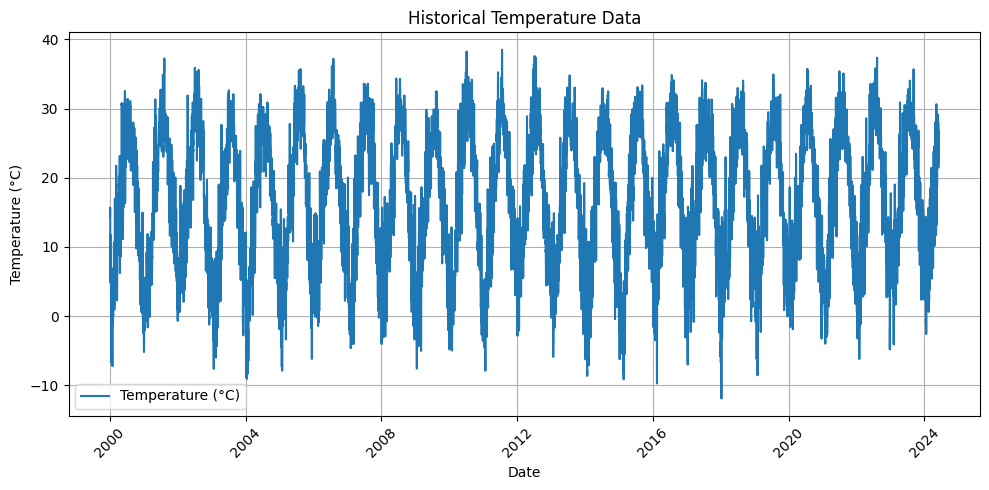

In [6]:
# Wyświetlenie danych na wykresie
start_datetime = "2000-01-01 00:00:00"
end_datetime = "2024-06-1 23:59:59"
plot_weather_data(data_daily, start_datetime=start_datetime, end_datetime=end_datetime)

## Zbieranie danych giełdowych

In [7]:
!pip install yfinance


In [8]:
import yfinance as yf

In [16]:

# Lista indeksów i ich symbole
indices = {
    'Dow Jones Industrial Average': '^DJI',
    'NASDAQ Composite': '^IXIC',
    'NASDAQ-100 Index': '^NDX',
    'S&P 500': '^GSPC',
    'Russell 2000 Index': '^RUT',
    'NYSE Composite Index': '^NYA',
    'NYSE Arca Tech 100 Index': '^NYFANG',
    'Dow Jones Transportation Average': '^DJT',
    'Dow Jones Utility Average': '^DJU',
    'NYSE Arca Biotechnology Index': '^BTK'
}

# Data początkowa i końcowa
start_date = "2000-01-01"
end_date = "2024-06-01"

volume_data = pd.DataFrame()
high_data = pd.DataFrame()
low_data = pd.DataFrame()

for index_name, symbol in indices.items():
    data = yf.download(symbol, start=start_date, end=end_date)
    volume_data[index_name] = data['Volume']
    high_data[index_name] = data['High']
    low_data[index_name] = data['Low']
# Wyświetlenie pierwszych kilku wierszy DataFrame
print(volume_data.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

            Dow Jones Industrial Average  NASDAQ Composite  NASDAQ-100 Index  \
Date                                                                           
2000-01-03                     169750000        1510070000        1510070000   
2000-01-04                     178420000        1511840000        1511840000   
2000-01-05                     203190000        1735670000        1735670000   
2000-01-06                     176550000        1598320000        1598320000   
2000-01-07                     184900000        1634930000        1634930000   

               S&P 500  Russell 2000 Index  NYSE Composite Index  \
Date                                                               
2000-01-03   931800000           931800000                     0   
2000-01-04  1009000000          1009000000                     0   
2000-01-05  1085500000          1085500000                     0   
2000-01-06  1092300000          1092300000                     0   
2000-01-07  1225200000         

In [22]:

def IntersectData(stock_data, data_daily):
  # Upewnij się, że indeksy są typu datetime
  stock_data.index = pd.to_datetime(stock_data.index)
  data_daily.index = pd.to_datetime(data_daily['date'])


  # Znalezienie wspólnych dat (przecięcie indeksów)
  common_dates = stock_data.index.intersection(data_daily.index)

  # Filtrowanie obu DataFrames, aby zachować tylko wspólne daty
  stock_data_filtered = stock_data.loc[common_dates]
  data_daily_filtered = data_daily.loc[common_dates]

  return volume_data_filtered, data_daily_filtered

volume_data_filtered, data_daily_filtered = IntersectData(volume_data, data_daily)

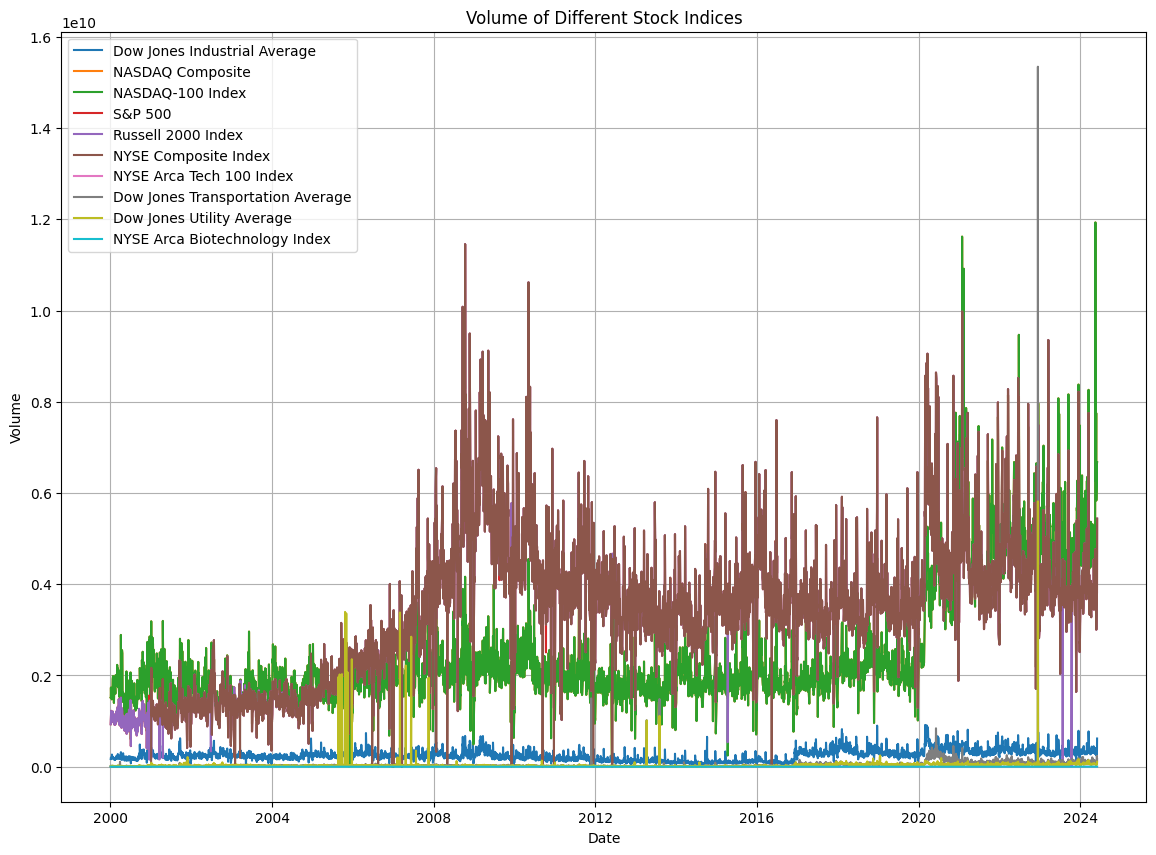

In [23]:
def plot_index_volumes(volume_data):

    # Rysowanie wykresów wolumenów dla każdego indeksu
    plt.figure(figsize=(14, 10))

    for column in volume_data.columns:
        plt.plot(volume_data.index, volume_data[column], label=column)

    plt.title('Volume of Different Stock Indices')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.show()


# Zakładamy, że masz już przefiltrowane DataFrame volume_data_filtered
# Przykładowe wywołanie funkcji
plot_index_volumes(volume_data_filtered)

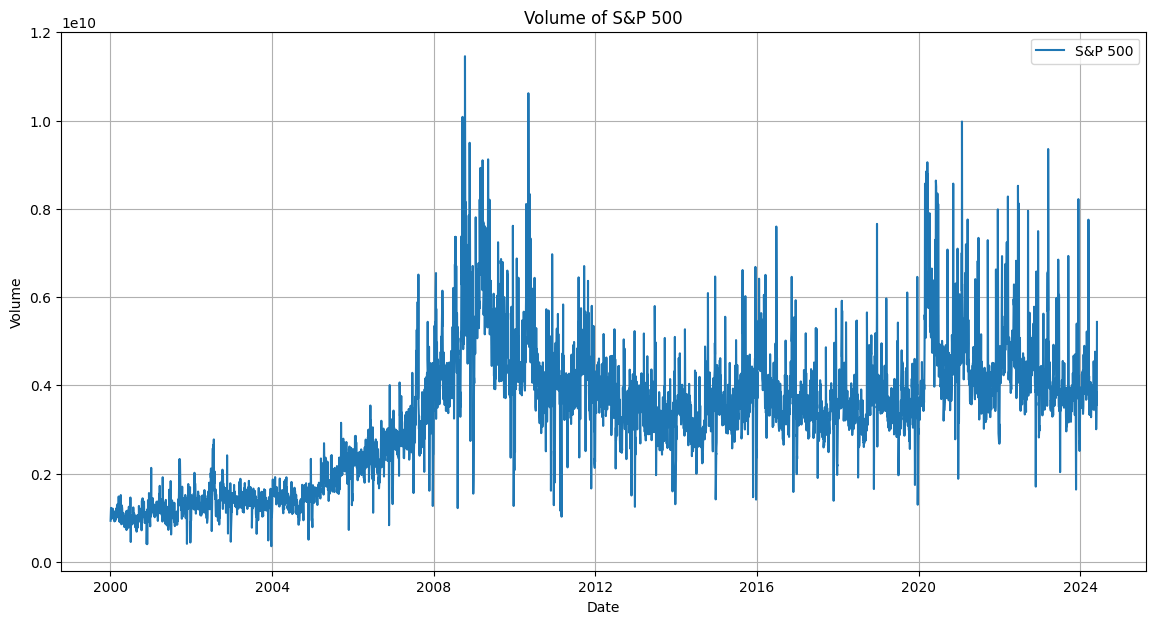

In [24]:
def plot_single_index_volume(volume_data, index_name):

    # Sprawdzenie, czy podana kolumna istnieje w DataFrame
    if index_name not in volume_data.columns:
        raise ValueError(f"Index {index_name} not found in the DataFrame columns")

    # Rysowanie wykresu wolumenu dla wybranego indeksu
    plt.figure(figsize=(14, 7))

    plt.plot(volume_data.index, volume_data[index_name], label=index_name)

    plt.title(f'Volume of {index_name}')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.show()

# Zakładamy, że masz już przefiltrowane DataFrame volume_data_filtered
# Przykładowe wywołanie funkcji
plot_single_index_volume(volume_data_filtered, 'S&P 500')

## Liczenie statystyk i zależności pomiędzy danymi

In [13]:
from scipy.stats import pearsonr

In [14]:
def calculate_correlation(weather_data, other_data):
    # Sprawdzenie, czy obie listy mają taką samą długość
    if len(weather_data) != len(other_data):
        raise ValueError("Lists must have the same length")

    # Obliczenie korelacji Pearsona
    correlation, _ = pearsonr(weather_data, other_data)

    return correlation


In [25]:
def calculate_volume_weather_correlation(volume_data, weather_data, weather_column, index_name):
    # Upewnij się, że indeksy są typu datetime
    volume_data.index = pd.to_datetime(volume_data.index)
    weather_data.index = pd.to_datetime(weather_data.index)

    # Połącz oba DataFrames w jeden na podstawie indeksów (dat)
    merged_data = pd.concat([volume_data, weather_data[weather_column]], axis=1, join='inner')

    # Oblicz korelację Pearsona
    correlation = merged_data[index_name].corr(merged_data[weather_column])

    return correlation

# Przykładowe wywołanie funkcji
# Zakładamy, że masz już przefiltrowane DataFrame volume_data_filtered i data_daily_filtered

weather_column = 'temperature_2m_max'

def Find_Correlation_Between_Volume_and_Weather(weather_column):
  print(weather_column)
  for index_name, symbol in indices.items():
    correlation = calculate_volume_weather_correlation(volume_data_filtered[index_name], data_daily_filtered, weather_column, index_name)

    print(f"Dla indeksu: {index_name} : Korelacja między wolumenem a {weather_column}: {correlation}")


for column in data_daily.columns:
  if(column!='datetime' and column!='date' and column!='time'):
    Find_Correlation_Between_Volume_and_Weather(column)

weather_code
Dla indeksu: Dow Jones Industrial Average : Korelacja między wolumenem a weather_code: 0.030478764016598044
Dla indeksu: NASDAQ Composite : Korelacja między wolumenem a weather_code: 0.03217452412736821
Dla indeksu: NASDAQ-100 Index : Korelacja między wolumenem a weather_code: 0.03306655946007583
Dla indeksu: S&P 500 : Korelacja między wolumenem a weather_code: 0.015019702645267797
Dla indeksu: Russell 2000 Index : Korelacja między wolumenem a weather_code: 0.014285364113603533
Dla indeksu: NYSE Composite Index : Korelacja między wolumenem a weather_code: 0.014821327115404345
Dla indeksu: NYSE Arca Tech 100 Index : Korelacja między wolumenem a weather_code: nan
Dla indeksu: Dow Jones Transportation Average : Korelacja między wolumenem a weather_code: 4.7710744619029944e-05
Dla indeksu: Dow Jones Utility Average : Korelacja między wolumenem a weather_code: 0.003949013786132685
Dla indeksu: NYSE Arca Biotechnology Index : Korelacja między wolumenem a weather_code: -0.0108329

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [35]:
def LinearRegressionTest(index_name, weather_param):
  # Połączenie danych
  data = pd.concat([data_daily_filtered,  volume_data_filtered], axis=1, join='inner')

  # Usuwanie wierszy z NaN
  data = data.dropna()

  X = data[[weather_param]].values
  y = data[index_name].values

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Tworzenie i trenowanie modelu regresji liniowej
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Predykcja
  y_pred = model.predict(X_test)

  # Ocena modelu
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f'Mean Squared Error: {mse}')
  print(f'R-squared: {r2}')

for index_name, symbol in indices.items():
  LinearRegressionTest(index_name, 'temperature_2m_mean')

Mean Squared Error: 1.840883556835369e+16
R-squared: 0.021523681171935594
Mean Squared Error: 2.8031268201471555e+18
R-squared: 0.005635562267484406
Mean Squared Error: 2.803262757623646e+18
R-squared: 0.005601696480121099
Mean Squared Error: 1.0594516060826866e+18
R-squared: 0.013276888050757885
Mean Squared Error: 1.0597896971402044e+18
R-squared: 0.012824806818843903
Mean Squared Error: 1.0596375658600618e+18
R-squared: 0.013103693910340719
Mean Squared Error: 0.0
R-squared: 1.0
Mean Squared Error: 4048485797207490.0
R-squared: -0.017082558239432055
Mean Squared Error: 522132759177647.5
R-squared: -0.022092545416049436
Mean Squared Error: 0.0
R-squared: 1.0


In [ ]:
def LinearRegressionTest(index_name, weather_param):
  # Połączenie danych
  data = pd.concat([data_daily_filtered,  volume_data_filtered], axis=1, join='inner')

  # Usuwanie wierszy z NaN
  data = data.dropna()

  X = data[[weather_param]].values
  y = data[index_name].values

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Tworzenie i trenowanie modelu regresji liniowej
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Predykcja
  y_pred = model.predict(X_test)

  # Ocena modelu
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f'Mean Squared Error: {mse}')
  print(f'R-squared: {r2}')

for index_name, symbol in indices.items():
  LinearRegressionTest(index_name, 'temperature_2m_mean')

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [39]:

def RandomForestTest(index_name, weather_param):
  # Połączenie danych
  data = pd.concat([data_daily_filtered,  volume_data_filtered], axis=1, join='inner')

  # Usuwanie wierszy z NaN
  data = data.dropna()

  X = data[[weather_param]].values
  y = data[index_name].values

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Tworzenie i trenowanie modelu regresji lasów losowych
  rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
  rf_model.fit(X_train, y_train)

  # Predykcja
  y_pred_rf = rf_model.predict(X_test)

  # Ocena modelu
  mse_rf = mean_squared_error(y_test, y_pred_rf)
  r2_rf = r2_score(y_test, y_pred_rf)
  print(f'Mean Squared Error (Random Forest): {mse_rf}')
  print(f'R-squared (Random Forest): {r2_rf}')

for index_name, symbol in indices.items():
  RandomForestTest(index_name, 'temperature_2m_mean')

Mean Squared Error (Random Forest): 2.7264888372611924e+16
R-squared (Random Forest): -0.449197995659931
Mean Squared Error (Random Forest): 3.8156475167685734e+18
R-squared (Random Forest): -0.3535399719795307
Mean Squared Error (Random Forest): 3.8158096291948995e+18
R-squared (Random Forest): -0.35357793753262223
Mean Squared Error (Random Forest): 1.4756119758496166e+18
R-squared (Random Forest): -0.3743151952202204
Mean Squared Error (Random Forest): 1.4756484620371295e+18
R-squared (Random Forest): -0.3745402125628161
Mean Squared Error (Random Forest): 1.475600008684228e+18
R-squared (Random Forest): -0.37430404956844576
Mean Squared Error (Random Forest): 0.0
R-squared (Random Forest): 1.0
Mean Squared Error (Random Forest): 2.2035624467330474e+17
R-squared (Random Forest): -54.359090850942295
Mean Squared Error (Random Forest): 3.161768424665785e+16
R-squared (Random Forest): -60.89268687665768
Mean Squared Error (Random Forest): 0.0
R-squared (Random Forest): 1.0


In [40]:
from sklearn.svm import SVR

In [43]:

def SVMTest(index_name, weather_param):
  # Połączenie danych
  data = pd.concat([data_daily_filtered,  volume_data_filtered], axis=1, join='inner')

  # Usuwanie wierszy z NaN
  data = data.dropna()

  X = data[[weather_param]].values
  y = data[index_name].values

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Tworzenie i trenowanie modelu SVR
  svr_model = SVR(kernel='rbf')  # Można wypróbować inne jądra, np. 'linear', 'poly'
  svr_model.fit(X_train, y_train)

  # Predykcja
  y_pred_svr = svr_model.predict(X_test)

  # Ocena modelu
  mse_svr = mean_squared_error(y_test, y_pred_svr)
  r2_svr = r2_score(y_test, y_pred_svr)
  print(f'Mean Squared Error (SVR): {mse_svr}')
  print(f'R-squared (SVR): {r2_svr}')

for index_name, symbol in indices.items():
  SVMTest(index_name, 'temperature_2m_max')

Mean Squared Error (SVR): 1.894321939113523e+16
R-squared (SVR): -0.0068801748902822535
Mean Squared Error (SVR): 3.627123169717297e+18
R-squared (SVR): -0.28666397300325497
Mean Squared Error (SVR): 3.627137893526455e+18
R-squared (SVR): -0.28665062101167815
Mean Squared Error (SVR): 1.1251555432314431e+18
R-squared (SVR): -0.047916651095831764
Mean Squared Error (SVR): 1.1249505567297636e+18
R-squared (SVR): -0.04787137123115204
Mean Squared Error (SVR): 1.1251555432314433e+18
R-squared (SVR): -0.04791665109583221
Mean Squared Error (SVR): 0.0
R-squared (SVR): 1.0
Mean Squared Error (SVR): 4253283357030835.5
R-squared (SVR): -0.06853291190252175
Mean Squared Error (SVR): 512229265930325.9
R-squared (SVR): -0.0027061222435060817
Mean Squared Error (SVR): 0.0
R-squared (SVR): 1.0


## Sekcja Api Spotify Python

In [ ]:
import base64
from  requests import post
import json
from collections import defaultdict
from datetime import datetime, timedelta
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [ ]:
CLIENT_ID = "7ea6484e8f28434f9580c32b948a22b8"
CLIENT_SECRET = "1af6a6d191284891bad5f66420165b74"

In [ ]:
def get_token():
    auth_string = CLIENT_ID + ":" + CLIENT_SECRET
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")
    url = "https://accounts.spotify.com/api/token"

    headers = {
        "Authorization" : "Basic " + auth_base64,
        "Content-Type" : "application/x-www-form-urlencoded"
    }

    data = {"grant_type" : "client_credentials"}
    result = post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result["access_token"]
    return token

token = get_token()


def get_auth_header(token):
  return {"Authorization" : "Bearer " + token}

In [ ]:
!pip install spotipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 8.3 MB/s eta 0:00:00


In [ ]:
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
artist_name = []
track_name = []
popularity = []
track_id = []
for i in range(0,100,50):
    track_results = sp.search(q='year:2023', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])

In [ ]:
print(artist_name)

['АйМон', 'Relaxing Instrumental Jazz Ensemble', 'Dilkhush Dilwala', 'ex blade', 'Mascote 013', 'スムーズジャズ', 'tomasplachet', 'Cafe Jazz BGM', 'Café Lounge', 'Natural Rain', 'Stephen DeCesare', 'Reading Jazz Lounge Background Music', 'Chilly Swing Band', 'Instrumental Suite', 'WORLD ELEMENT', 'Sunny Tanager', 'Relajarse Lluvia', 'Dulces Sueños', 'Essential Dinner Party Background Music', 'Trudi Mogush', 'Deep Sleep Rain Sounds', 'Cafe Music Deluxe', 'Musica Para Dormir y Sonidos de la Naturaleza', 'T&B Rhythm', 'Coco Breeze', 'Elevator Music Universe', 'Tunetank', 'Simply Color', 'Ylfree', 'Icerackbeatz', 'Tommy TwoPhones', 'Joker Beats', 'Maria Piano', 'TUNEL DEL GHETTO', 'iamdjstrain', 'KG HIP HOP BEATS', 'Fine Dining Lounge', 'Oops Guess', 'Infectious Antxiety', 'Leo Tolstoy', 'Thunderstorms', 'Coffee Table Jazz Radio', 'Dj Diva', 'Sleep Crickets', 'The Land Seven', 'Marie Chain', 'Jazz Sax Relax', 'Help Me Sleep', 'Nature Sound Collection', 'Comfort Night Blessing', 'Study Piano Music